# Ejemplo inferencia con TPU

## <span style="color:red">J. Oriol Moreno Usó</span> 

## Librerias

In [80]:
import cv2
import os
import copy
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
#import tensorflow as tf

import pycoral
from pycoral.adapters.common import input_details
from pycoral.adapters.common import output_tensor
from pycoral.utils.edgetpu import make_interpreter
from pycoral.utils.edgetpu import run_inference

## Carga modelo e imagen

In [58]:
path='./data/cityscapes_data/val'
def images_upload(path):
    images=[]
    for root,subfolders,files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endwith('png'):
                images.append(filename)
    return images
images=images_upload(path)

100%|██████████| 500/500 [00:00<00:00, 925486.32it/s]


In [59]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB )
        del i
        imgs.append(img)
    return imgs
img=convert_image_rgb(images)

100%|██████████| 500/500 [00:00<00:00, 662.80it/s]


In [60]:
def split_input_mask(data):
    inputs = []
    mask = []
    for i in data:
        a = i[:,:256]
        a = cv2.resize(a, (256, 96))
        inputs.append(a)

        b = i[:,256:]
        b = cv2.resize(b, (256, 96))
        mask.append(b)
    inputs_norm = np.array([item for item in inputs])
    return inputs_norm, np.array(mask)
inputs, mask = split_input_mask(img)

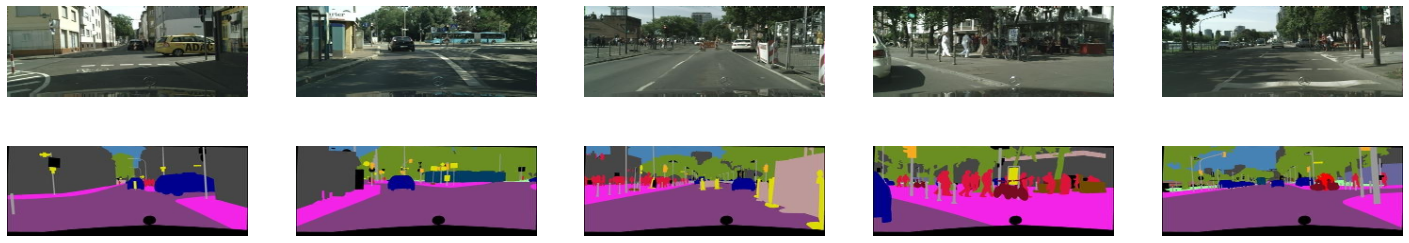

In [61]:
idx = [3, 5, 0, 4, 10]

plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.05)

for k in range(len(idx)):
    plt.subplot(2, 5, k + 1)
    plt.imshow(abs(inputs[k]))
    plt.axis('off')
    plt.subplot(2, 5, k + 6)
    plt.imshow(mask[k])
    plt.axis('off')
plt.show()

In [62]:
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), 
                   (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), 
                   ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)], dtype = np.int8)

img_height, img_width, channels = 96, 256, 3
num_classes = 30

Dado que pycoral es incompatible con cualquier tipo de carga de tensorflow o keras, la única forma de cargar los datos es cargarlos desde local.

In [93]:
# Paths a los dos modelos
model_path_quant = "./quant_models/cityscapes/best_model_new_unet_upsampling_edgetpu.tflite"
model_path_gdc = "./quant_models/cityscapes/unet_v2_upsampling_gdn_edgetpu.tflite"

## Modelo unet upsampling compilado para TPU

In [ ]:
interpreter = make_interpreter(model_path_quant) # Genereramos/cargamos el objeto modelo
interpreter.allocate_tensors() # Lo enviamos a TPU
inference_size = input_details(interpreter, 'shape') # Recogemos el input shape del modelo

### Reconstrucción/Inferencia

In [ ]:
inference_size

array([  1,  96, 256,   3])

In [ ]:
t1 = time.time()
images = [] # Lista para guardar la reconstruccion de cada imagen

for img in inputs:
    # cv2_im = np.reshape(img, inference_size) # Cambio de shape para que encaje con el tamaño de input
    run_inference(interpreter, img.flatten()) # Inferencia
    reconstruction = output_tensor(interpreter,0) # Recogemos la reconstrucción
    img_rec = copy.copy(reconstruction) # Hacemos una copia de cada imagen reconstruída dado que reconstruction es mutable
    images.append(img_rec) # Añadimos cada imagen reconstruida a la lista

images_ = np.reshape(np.array(images), (len(images), img_height, img_width, 30))
results = np.argmax(images_, axis = 3)
t2 = time.time()
print(f"Execute time: {round(t2 - t1, 2)} segs")
print(f"Fps: {len(inputs)//(t2 - t1)}")

Execute time: 50.54 segs
Fps: 9.0


El uso de np.arrays es mucho más eficiente que el uso de listas.

Puesto que el *batch* que acepta el modelo es *(1, 28, 28, 1)* tenemos que enviar las imágenes de una en una,    
y como *reconstruction* es mutable, hace falta una copia real (no link) para poder guardar cada imagen reconstruida.

Como podemos observar, la diferencia de tiempo en inferencia entre el modelo en CPU y TPU es en este caso de x17.

Para una aproximación más óptima, es interesante observar cual es el tamaño de *batch* que minimiza el tiempo de inferencia.

In [ ]:
def one_hot_to_color_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, channels)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = color_mask.astype("int32")

    return color_mask

### Observarmos las reconstrucciones frente a las originales

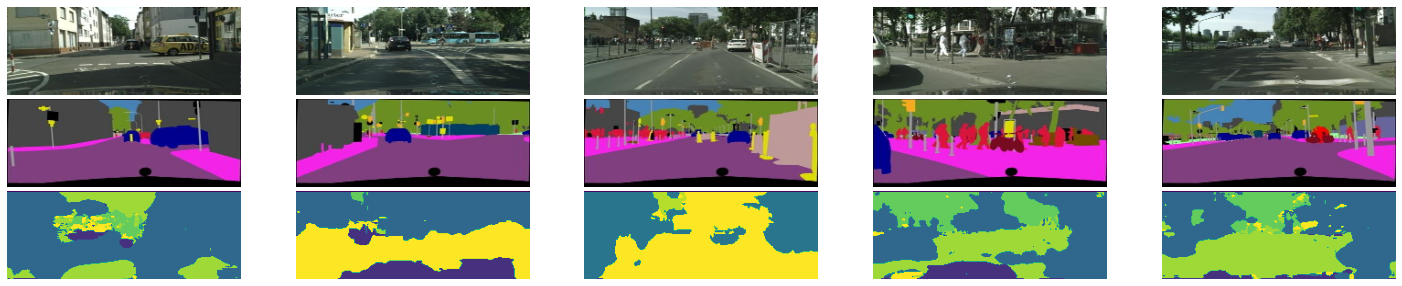

In [ ]:
idx = [random.randint(0,len(inputs)) for i in range(5)]
preds_ = results[idx]

plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.05)

for k in range(len(idx)):
    plt.subplot(3, 5, k + 1)
    plt.imshow(inputs[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 6)
    plt.imshow(mask[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 11)
    plt.imshow(preds_[k])
    plt.axis('off')
plt.show()

## Modelo unet GDC upsampling compilado para TPU

In [94]:
interpreter = make_interpreter(model_path_gdc) # Genereramos/cargamos el objeto modelo
interpreter.allocate_tensors() # Lo enviamos a TPU
inference_size = input_details(interpreter, 'shape') # Recogemos el input shape del modelo

### Reconstrucción/Inferencia

In [101]:
t1 = time.time()
images = [] # Lista para guardar la reconstruccion de cada imagen

for img in inputs[:5]:
    # cv2_im = np.reshape(img, inference_size) # Cambio de shape para que encaje con el tamaño de input
    run_inference(interpreter, img.flatten()) # Inferencia
    reconstruction = output_tensor(interpreter,0) # Recogemos la reconstrucción
    img_rec = copy.copy(reconstruction) # Hacemos una copia de cada imagen reconstruída dado que reconstruction es mutable
    images.append(img_rec) # Añadimos cada imagen reconstruida a la lista

images_ = np.reshape(np.array(images), (len(images), img_height, img_width, 30))
results = np.argmax(images_, axis = 3)
t2 = time.time()
print(f"Execute time: {round(t2 - t1, 2)} segs")
print(f"Fps: {round(5/(t2 - t1), 2)}")

Execute time: 55.59 segs
Fps: 0.09


El uso de np.arrays es mucho más eficiente que el uso de listas.

Puesto que el *batch* que acepta el modelo es *(1, 28, 28, 1)* tenemos que enviar las imágenes de una en una,    
y como *reconstruction* es mutable, hace falta una copia real (no link) para poder guardar cada imagen reconstruida.

Como podemos observar, la diferencia de tiempo en inferencia entre el modelo en CPU y TPU es en este caso de x17.

Para una aproximación más óptima, es interesante observar cual es el tamaño de *batch* que minimiza el tiempo de inferencia.

In [97]:
def one_hot_to_color_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, channels)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = color_mask.astype("int32")

    return color_mask

### Observarmos las reconstrucciones frente a las originales

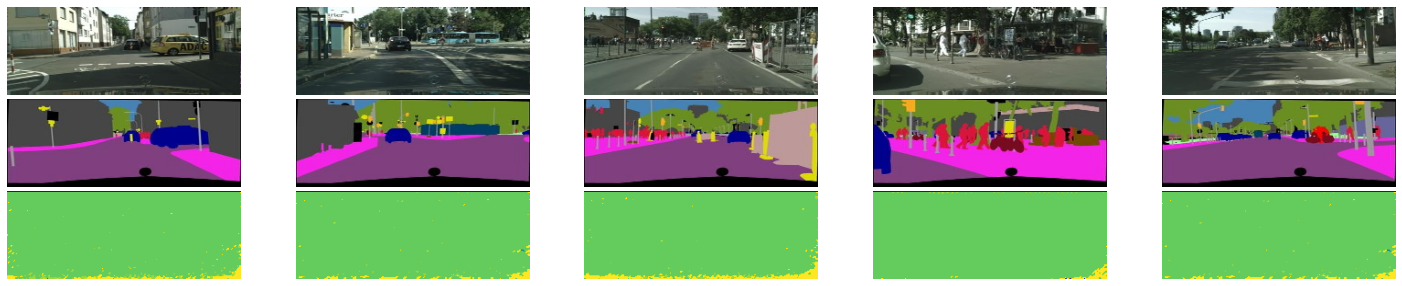

In [100]:
idx = [random.randint(0,4) for i in range(5)]
preds_ = results[idx]

plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.05)

for k in range(len(idx)):
    plt.subplot(3, 5, k + 1)
    plt.imshow(inputs[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 6)
    plt.imshow(mask[k])
    plt.axis('off')
    plt.subplot(3, 5, k + 11)
    plt.imshow(preds_[k])
    plt.axis('off')
plt.show()